# Small Data: Performance Analysis and Boosting in Python

The following work deals with performance issues in an existing program for data extraction from an API for timeseries measurement values. The code was growing over time and has therefore never been rethought to improve it from a basis. In addition, no performance analysis has ever been conducted for this piece of code.

The following work is showing how and how much I could improve...

*...the performance of data retrieval via REST API*

*...parsing of JSON encoded timeseries data*

*...and saving it into a .csv file?*



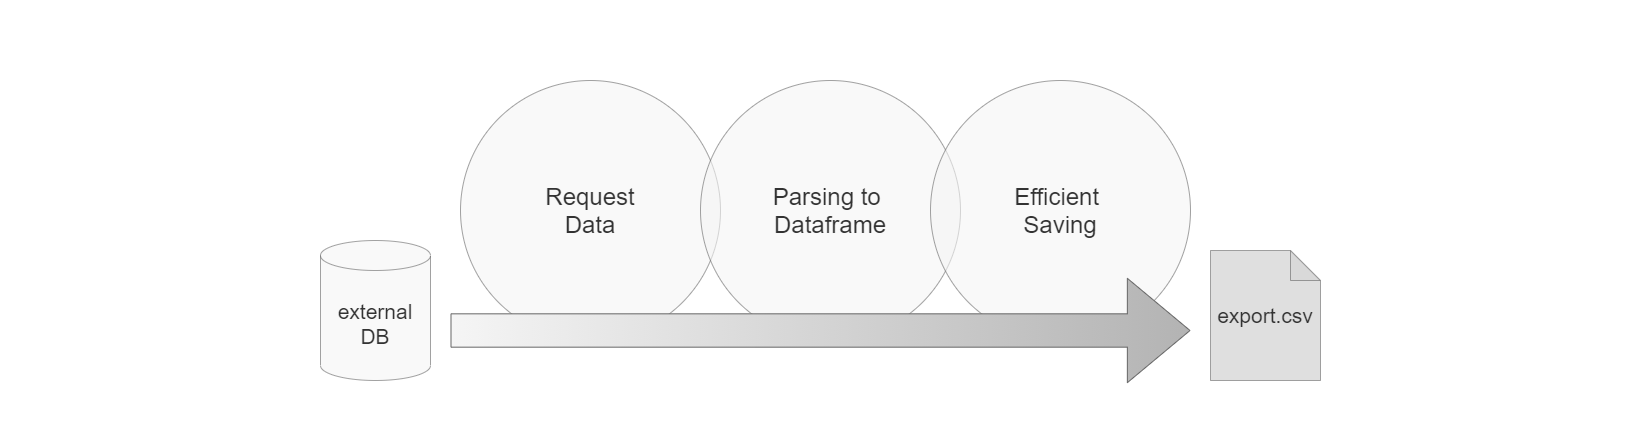

In [1]:
from IPython.display import Image
Image(filename='C:/Users/Diewald.Nicole/Documents/FH/3_Semester/Big_Data/flowchart_small_data.png')

**Initial Thoughts and Plan:** 
- Analysis of the state of the Art - which part takes how much time?
- Improve Performance of REST API request by varying request time horizons
- Improve parsing of json files
- Improve overall Performance by using Multithreading


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Small-Data:-Performance-Analysis-and-Boosting-in-Python" data-toc-modified-id="Small-Data:-Performance-Analysis-and-Boosting-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Small Data: Performance Analysis and Boosting in Python</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Benchmark</a></span></li><li><span><a href="#Performance-Improvements" data-toc-modified-id="Performance-Improvements-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Performance Improvements</a></span><ul class="toc-item"><li><span><a href="#Improve-Performance-of-REST-API-request-by-varying-request-time-horizons" data-toc-modified-id="Improve-Performance-of-REST-API-request-by-varying-request-time-horizons-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Improve Performance of REST API request by varying request time horizons</a></span></li><li><span><a href="#Improve-parsing-of-json-files" data-toc-modified-id="Improve-parsing-of-json-files-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Improve parsing of json files</a></span></li><li><span><a href="#Improve-overall-Performance-by-using-Parallel-Computation" data-toc-modified-id="Improve-overall-Performance-by-using-Parallel-Computation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Improve overall Performance by using Parallel Computation</a></span></li><li><span><a href="#Using-Dask" data-toc-modified-id="Using-Dask-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Using Dask</a></span></li><li><span><a href="#Reading-from-.csv-file" data-toc-modified-id="Reading-from-.csv-file-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Reading from .csv file</a></span></li></ul></li><li><span><a href="#Summary-and-Conclusion" data-toc-modified-id="Summary-and-Conclusion-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Summary and Conclusion</a></span><ul class="toc-item"><li><span><a href="#so...-boost-yourself-to-boost-your-code!" data-toc-modified-id="so...-boost-yourself-to-boost-your-code!-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>so... boost yourself to boost your code!</a></span></li></ul></li></ul></li></ul></div>

In [2]:
# Package Imports and General Definitions
import timeit
import request
import json
import requests
import pandas as pd
import datetime
from dateutil import tz
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

from api_requ import datapi_channels_fields, datapi_energy_forecast
from get_channels import get_all_channels
from get_pvsystems import get_pvsystems
from parse import parse_json
from request_process import get_dataframe_from_api

# DEFINE START AND STOP TIME OF DATA
start_day=datetime.date(2019, 6, 1)
until_day=datetime.date(2020, 5, 31)

# DEFINE SYSTEMS AND FILENAME
filename = 'Export_soa.csv'
export_path = './export_files/'
pvsystemid = 'b71cc02a-d75c-4bd7-a35e-cda5702e0da2'

channels = ['UACMeanL1','UACMeanL2', 'UACMeanL3']
# 'PowerReactive', 'PowerApparent',
#  'DevWork', 'CosPhi', 'IACMeanL1', 'IACMeanL2', 'IACMeanL3', 'GridApparentPowerPhase1', 'GridApparentPowerPhase2',
#   'GridApparentPowerPhase3', 'GridPowerAcPhase1', 'GridPowerAcPhase2', 'GridPowerAcPhase3',
#   'GridVoltageAcPhase1', 'GridVoltageAcPhase2', 'GridVoltageAcPhase3']

formatlogdt="%Y-%m-%dT%H:%M:%S.007Z"


## Benchmark
In order to have a **baseline for comparison**, at first the existing functions used are shown. This includes:
- function for the api request (datapi_channels_fields) (*not shown here*)
- function for parsing (parse_json)
- main function (baseline)

The script is based on an older version starting from a time with no python knowledge at all, and and was evolving over time. For example, is was taken as a given fact that only two days at once can be retrieved from the API, based on an older version of this API. However, this restriction changed and also longer time horizons can be retrieved at once now. The 'baseline' function is already adapted in a way so that it supports later used varying time horizons (days to request at once).

The **benchmark time** for this initial version can be found in the **later chapter 1.2.1**.

In [3]:
def datapi_channels_fields (start, end, channels, pvsystemid):

    headers = {'content-type': 'application/json'}
    url = "http://at-esxvm-646/data/v3/Pvs/QueryDataWithChannelsAndFields"

    data = {
        "Begin": start.strftime("%Y-%m-%dT%H:%M:%S"),
        "End": end.strftime("%Y-%m-%dT%H:%M:%S"),
        "PvSystemId": pvsystemid,
        "Channels": channels,
        "Fields" : ['ChannelType','Value','LogDt','NodeType', 'TargetDuration', 'DeviceId'],
        "TargetInterval": 0
    }
    #print("Request: {}".format(data))

    r = requests.post(url, data=json.dumps(data), headers=headers)
    if r.status_code != 200:
        print("Warning - StatusCode: {}".format(r.status_code))
        print(r.json())

    j = r.json()

    return j

In [4]:
# function to parse the json string
def parse_json(j):
    # define complete array with timestamps
    interval = datetime.timedelta(minutes=30)
    interval_current = datetime.timedelta(minutes=datetime.datetime.strptime(j['Records'][2]['TargetDuration'], '%H:%M:%S').time().minute)
    if interval_current < interval:
        interval = interval_current
    data_twodays = pd.DataFrame()

    for a in j['Records']:
        if a['Value'] is not None:
            rec_deviceid = a['DeviceId']

            rec_key = str(a['ChannelType'] + '_' + str(a['NodeType']) + str(' [') + str(a['Value']['Unit']) + str(']'))
            rec_value = a['Value']['Value']
            rec_logdt_dt = datetime.datetime.strptime(a['LogDt'], '%Y-%m-%dT%H:%M:%SZ')
            rec_logdt_UTC = rec_logdt_dt.replace(tzinfo=tz.tzutc())
            data_twodays.at[rec_logdt_UTC, rec_key] = rec_value

    return data_twodays, interval

In [5]:
def baseline(days):

    filename = pvsystemid + '.csv'

    #######################################################################################################################
    # init arrays for request timestamp
    timespan=int(np.ceil((until_day + datetime.timedelta(days=1) - start_day).days/days))
    print(timespan)
    period=datetime.timedelta(days = days, hours=0, minutes=0)
    print(period)
    startdate_list=[]
    for x in range(0, (timespan)):
        startdate_list.append([datetime.datetime.combine(start_day, datetime.time(0, 0)) + period*x][0])

    # init data frame for export (overall data)
    df_all = pd.DataFrame()
    ######################################################################################################################
    soa_api_requ = []
    soa_parsing = []
    soa_parsing_days = []
    soa_api_requ_days = []
    #print(startdate_list)
    # loop over list with startdates
    for requ_start in startdate_list:
        requ_end = requ_start + period - datetime.timedelta(minutes=1)
        if requ_end.date() > until_day:
            print('yes')
            requ_end = datetime.datetime.combine(until_day, datetime.time(23, 59))
        # print(f'{requ_start} to {requ_end}')
        delta = (requ_end + datetime.timedelta(minutes=1) -requ_start).days
        # request from api
        starttime = timeit.default_timer()
        j = datapi_channels_fields(requ_start, requ_end, channels, pvsystemid)
        end_api_requ = timeit.default_timer() - starttime
        soa_api_requ.append([end_api_requ])
        soa_api_requ_days.append([end_api_requ/delta])

        # check output
        if j['Records'] == []:
            continue

        # get tz
        olson_tz = tz.gettz(j['Olson'])

        #print(j)
        
        # parse json to data frame & add timezone info (UTC)
        starttime_parsing = timeit.default_timer()
        data_twodays, interval = parse_json(j)
        end_parse = timeit.default_timer() - starttime_parsing
        soa_parsing.append([end_parse])
        soa_parsing_days.append([end_parse/delta])

        # add to overall data frame
        df_all = pd.concat([df_all, data_twodays], sort=True)

    ######################################################################################################################
    # fill missing timestamps
    test = pd.date_range(start=min(df_all.index), freq=interval, end=max(df_all.index))

    df_all=df_all.reindex(index=test)

    # convert to local time
    df_all = df_all.tz_convert(olson_tz)
    df_all.index.name = "DateTime"
    
    return df_all, soa_api_requ, soa_parsing, soa_api_requ_days, soa_parsing_days

## Performance Improvements

In order to improve the performance of this application, at first it has to be found out **which part takes longest** and a benchmark has to be set. Therefore, the Python **"timeit"** module is used to track the durations of the request itself as well as the parsing. This task is combined with the first analysis of possible improvements:

### Improve Performance of REST API request by varying request time horizons

Firstly, the **time horizon for the request is varied** - so that not only just two days at once are retrieved from the API, but also longer time horizons. Therefore, the initial baseline function is adapted to enable this time horizons instead of a hard coded two days interval. **The 2_days result is the benchmark time for the analysis**. The code below defines a list with the time horizons used for comparison.

In [6]:
# define a list of varying time horizons for the request
days_list = [1, 2, 7, 14, 30, 60, 120]
days_names = [str(d) + '_days' for d in days_list]
days_names

['1_days', '2_days', '7_days', '14_days', '30_days', '60_days', '120_days']

In [7]:
# # run the functions above with the varying time horizons

# # predefine dataframe for timeit results
# df_timer = pd.DataFrame(index = days_names, columns = ['api_per_day_s', 
#                                                         'parsing_per_day_s', 
#                                                         'api_sum_s',
#                                                         'parsing_sum_s',
#                                                         'parsing/api',
#                                                         'summe_s'])
# for x in range(0,len(days_list)):
#     days = days_list[x]
    
#     df_all, soa_api_requ, soa_parsing , soa_api_requ_days, soa_parsing_days = baseline(days)
    
#     summe = np.sum(soa_api_requ) + np.sum(soa_parsing)

#     df_timer.loc[days_names[x]] = [np.mean(soa_api_requ_days), 
#                                     np.mean(soa_parsing_days), 
#                                     np.sum(soa_parsing), 
#                                     np.sum(soa_api_requ),
#                                     np.sum(soa_parsing)/np.sum(soa_api_requ),
#                                     summe]
# #     print(df_timer)

#     print(f'summe: {summe/60} min')
#     print(len(df_all))

In [8]:
df_timer = pd.DataFrame(index = days_names, columns = ['api_per_day_s', 
                                                        'parsing_per_day_s', 
                                                        'api_sum_s',
                                                        'parsing_sum_s',
                                                        'parsing/api',
                                                        'summe_s'])
for x in range(0,len(days_list)):
    days = days_list[x]
    
    df_all, soa_api_requ, soa_parsing , soa_api_requ_days, soa_parsing_days = baseline(days)
    
    summe = np.sum(soa_api_requ) + np.sum(soa_parsing)

    df_timer.loc[days_names[x]] = [np.mean(soa_api_requ_days), 
                                    np.mean(soa_parsing_days), 
                                    np.sum(soa_api_requ), 
                                    np.sum(soa_parsing),
                                    np.sum(soa_parsing)/np.sum(soa_api_requ),
                                    summe]
#     print(df_timer)

    print(f'summe: {summe/60} min')
    print(len(df_all))

366
1 day, 0:00:00
summe: 7.29051415333333 min
105408
183
2 days, 0:00:00
summe: 5.553216708333343 min
105408
53
7 days, 0:00:00
yes
summe: 5.146136413333337 min
105408
27
14 days, 0:00:00
yes
summe: 5.1153471766666865 min
105408
13
30 days, 0:00:00
yes
summe: 5.369799946666672 min
105408
7
60 days, 0:00:00
yes
summe: 6.064675789999997 min
105408
4
120 days, 0:00:00
yes
summe: 7.419700080000007 min
105408


The table below shows the difference of the time needed for the **API request** as well as for **parsing**, for **varying time horizons from 1 day to 120 days** within one request:
- *api_per_day_s* are the seconds needed to get the data from the api for one day (mean)
- *parsing_per_day_s* are the seconds needed to parse the data for one day (mean)
- *api_sum_s* is the overall time taken by the api request (sum)
- *parsing_sum_s* is the overall time taken for parsing (sum)
- *parsing/api* is the ratio between parsing and the api duration sums
- *summe_s* is the overall sum to get the data back as a data frame

In [9]:
print(tabulate(df_timer, headers='keys', tablefmt='psql'))

+----------+-----------------+---------------------+-------------+-----------------+---------------+-----------+
|          |   api_per_day_s |   parsing_per_day_s |   api_sum_s |   parsing_sum_s |   parsing/api |   summe_s |
|----------+-----------------+---------------------+-------------+-----------------+---------------+-----------|
| 1_days   |        0.690299 |            0.504868 |     252.649 |         184.782 |      0.731376 |   437.431 |
| 2_days   |        0.500224 |            0.41014  |     183.082 |         150.111 |      0.819913 |   333.193 |
| 7_days   |        0.398473 |            0.445554 |     145.54  |         163.228 |      1.12153  |   308.768 |
| 14_days  |        0.379627 |            0.457699 |     138.448 |         168.473 |      1.21687  |   306.921 |
| 30_days  |        0.384981 |            0.492183 |     139.938 |         182.25  |      1.30236  |   322.188 |
| 60_days  |        0.383172 |            0.602623 |     133.524 |         230.357 |      1.7252

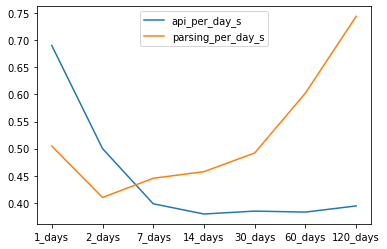

In [14]:
df_timer[['api_per_day_s',
         'parsing_per_day_s']].plot.line()

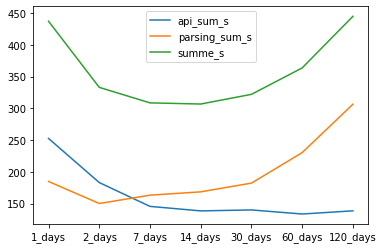

In [15]:
df_timer[['api_sum_s','parsing_sum_s', 'summe_s']].plot.line()

The diagrams above show that there is not much difference of the time needed for the API request starting from 7 days at once. Requesting only 1 or 2 days however takes longer, most probably because the connection to the host has to be built up so many times. From the pictures and table above, a request of **60 days** seemts to be the best option. The time needed for a request is increasing again slightly for 120 days. The time for parsing should not be considered at this stage because to approach will change in the next chapter.

### Improve parsing of json files

The JSON string retrieved from the API is **nested** and therefore not easy to parse to a tabular format as needed in the exports. Here is an example:


In [16]:
j = '''{
  "Records": [
    {
      "ChannelType": "UACMeanL1",
      "Value": {
        "Value": 0,
        "Unit": "Voltage_100mV"
      },
      "Validity": "Calculated",
      "TargetDuration": "00:05:00",
      "Duration": "00:04:59",
      "TemplateId": null,
      "DataSourceIdentity": {
        "DataSourceId": "240.198074",
        "DataSourceType": "Datamanager"
      },
      "LastModifiedDt": "2019-06-01T04:01:07.9053",
      "LogDt": "2019-05-31T22:00:00Z",
      "NodeType": 97,
      "DeviceType": 123,
      "Idx": 28,
      "ComponentId": null,
      "DeviceId": "2142085f-a929-4e29-adbc-aa4b00acd810"
    },
  ],
  "Olson": "Europe/Berlin",
  "Error": null
}'''

It contains the "Records" with all the required data, and the **timezone** ("Olson"). The timezone is needed to convert the data to local time from UTC. One **ChannelType** should be one column, the **LogDt** should be the datetime index. There is also a **NodeType** which enumerates the number of the inverter in the PvSystem. If there are multiple inverters in the system, the UACMeanL1 channel exists multiple times, once for each inverter and therefore there must be a column in the dataframe depending on the ChannelType AND NodeType combination. Also the **Unit** is an important information to be added to the export file.



The **procedure of the initial solution** works as follows:
1. data of two days is requested
2. JSON is given to the parsing function
3. the time interval (can be 5, 15 or 30 minutes) is read from the first entries
4. an empty dataframe for the two days data is initiated
5. a *for* loop iterates over each "Records" entry in the JSON string:
    - it defines a columns key with the ChannelType, NodeType and Unit of the record
    - it uses the LogDt as the index for the record
    - it adds utc timezone info to every LogDt
    - it uses the pandas.at method to save the value at the corresponding column and index
6. the dataframe is returned to the main function and there concatenated to the dataframe containing all the values (attaching two more days of data in each loop)
7. At the end, missing timestamps are filled with NaN values and the timezone is changed to local time for the overall dataframe.

As an **improvement strategy**, a performance comparison is made by replacing the use of the **pandas "at"** function. Instead, the data is being **parsed in a dictionary** and transformed to a dataframe in the end. For the experiment, a locally saved JSON file with only two days of data is read in. The data is equal to the data requested via the API. The test file can be found in the Git repository for reproducability.

In [17]:
# new function to parse the json string with dict
def parse_json_new(j):
    # define complete array with timestamps
    interval = datetime.timedelta(minutes=30)
    interval_current = datetime.timedelta(minutes=datetime.datetime.strptime(j['Records'][2]['TargetDuration'], '%H:%M:%S').time().minute)
    if interval_current < interval:
        interval = interval_current
        
    data_twodays = {}

    for a in j['Records']:
        if a['Value'] is not None:
            try:
                rec_key = str(a['ChannelType'] + '_' + str(a['NodeType']) + str(' [') + str(a['Value']['Unit']) + ']')            
                data_twodays[rec_key].update(
                    {str(datetime.datetime.strptime(a['LogDt'], "%Y-%m-%dT%H:%M:%SZ")): a['Value']['Value'],                    }
                    )
            except KeyError:
                data_twodays[rec_key] = {}
            
    data_twodays = pd.DataFrame(data_twodays)
    data_twodays.index = pd.to_datetime(data_twodays.index).tz_localize(tz='utc')

    return data_twodays, interval

The new parsing is tested by using an offline saved .json export for reproducability of this part of the analysis. The file contains two days of data and is available in the repository. Following code is used to compare the time needed by the parsing functions:

In [18]:
with open ('test_json_2d.txt') as f:
    j = json.load(f)
#print(j)

faster = []
for x in range(0,100):
    starttime_parsing = timeit.default_timer()
    df, interval = parse_json_new(j)
    parse_json_new_time = timeit.default_timer() - starttime_parsing

    starttime_parsing = timeit.default_timer()
    df_base, interval = parse_json(j)
    parse_json_base = timeit.default_timer() - starttime_parsing

    faster.append(parse_json_base/parse_json_new_time)

# print(f'duration for parse_json2: {parse_json_new_time}')
# print(f'duration for parse_json: {parse_json_base}')
print(f'{np.mean(faster)} times faster!!')

25.19350641976238 times faster!!


In [19]:
# compare the output - looks the same with both parsing functions?
print(tabulate(df[80:85], headers='keys', tablefmt='psql'))

+---------------------------+--------------------------------+--------------------------------+--------------------------------+
|                           |   UACMeanL1_97 [Voltage_100mV] |   UACMeanL2_97 [Voltage_100mV] |   UACMeanL3_97 [Voltage_100mV] |
|---------------------------+--------------------------------+--------------------------------+--------------------------------|
| 2019-06-01 04:45:00+00:00 |                        2307    |                        2265    |                        2324    |
| 2019-06-01 04:50:00+00:00 |                        2308.95 |                        2258.01 |                        2322.95 |
| 2019-06-01 04:55:00+00:00 |                        2301.9  |                        2259.04 |                        2316    |
| 2019-06-01 05:00:00+00:00 |                        2287    |                        2265    |                        2316    |
| 2019-06-01 05:05:00+00:00 |                        2289.03 |                        2266.96 |  

In [20]:
print(tabulate(df_base[80:85], headers='keys', tablefmt='psql'))

+---------------------------+--------------------------------+--------------------------------+--------------------------------+
|                           |   UACMeanL1_97 [Voltage_100mV] |   UACMeanL2_97 [Voltage_100mV] |   UACMeanL3_97 [Voltage_100mV] |
|---------------------------+--------------------------------+--------------------------------+--------------------------------|
| 2019-06-01 04:40:00+00:00 |                        2308.99 |                        2262.02 |                        2321.02 |
| 2019-06-01 04:45:00+00:00 |                        2307    |                        2265    |                        2324    |
| 2019-06-01 04:50:00+00:00 |                        2308.95 |                        2258.01 |                        2322.95 |
| 2019-06-01 04:55:00+00:00 |                        2301.9  |                        2259.04 |                        2316    |
| 2019-06-01 05:00:00+00:00 |                        2287    |                        2265    |  

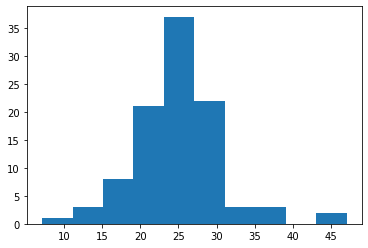

In [21]:
# show histogram of time ratio
plt.hist(faster)
plt.show()

The code above repeated the parsing procedure 100 times since the performance is varying heavily in each iteration. **It parses in each iteration once with the baseline parsing function and once with the new one.** Then, it adds the **time ratio between the new and the old function** to a list. The outcome is printed below the code block and also shown in the histogram plot above: the new version is around **25 times faster in parsing** compared to the old one.
Looking back at the table from the varying time horizons, this means an improvement from ~200 down to 8 seconds for parsing!

In [22]:
def baseline_new_parse(days):

    filename = pvsystemid + '.csv'

    #######################################################################################################################
    # init arrays for request timestamp
    timespan=int(np.ceil((until_day + datetime.timedelta(days=1) - start_day).days/days))
    print(timespan)
    period=datetime.timedelta(days = days, hours=0, minutes=0)
    print(period)
    startdate_list=[]
    for x in range(0, (timespan)):
        startdate_list.append([datetime.datetime.combine(start_day, datetime.time(0, 0)) + period*x][0])

    # init data frame for export (overall data)
    df_all = pd.DataFrame()
    ######################################################################################################################
    soa_api_requ = []
    soa_parsing = []
    soa_parsing_days = []
    soa_api_requ_days = []
    #print(startdate_list)
    # loop over list with startdates
    for requ_start in startdate_list:
        requ_end = requ_start + period - datetime.timedelta(minutes=1)
        if requ_end.date() > until_day:
            print('yes')
            requ_end = datetime.datetime.combine(until_day, datetime.time(23, 59))
        # print(f'{requ_start} to {requ_end}')
        delta = (requ_end + datetime.timedelta(minutes=1) -requ_start).days
        # request from api
        starttime = timeit.default_timer()
        j = datapi_channels_fields(requ_start, requ_end, channels, pvsystemid)
        end_api_requ = timeit.default_timer() - starttime
        print(f'api: {end_api_requ}')
        soa_api_requ.append([end_api_requ])
        soa_api_requ_days.append([end_api_requ/delta])

        # check output
        if j['Records'] == []:
            continue

        # get tz
        olson_tz = tz.gettz(j['Olson'])

        #print(j)
        
        # parse json to data frame & add timezone info (UTC)
        starttime_parsing = timeit.default_timer()
        data_twodays, interval = parse_json_new(j)
        end_parse = timeit.default_timer() - starttime_parsing
        print(f'parse: {end_parse}')

        soa_parsing.append([end_parse])
        soa_parsing_days.append([end_parse/delta])

        # add to overall data frame
        df_all = pd.concat([df_all, data_twodays], sort=True)

    ######################################################################################################################
    # fill missing timestamps
    test = pd.date_range(start=min(df_all.index), freq=interval, end=max(df_all.index))

    df_all=df_all.reindex(index=test)

    # convert to local time
    df_all = df_all.tz_convert(olson_tz)
    df_all.index.name = "DateTime"
    
    return df_all, soa_api_requ, soa_parsing, soa_api_requ_days, soa_parsing_days

In [ ]:
# df_timer = pd.DataFrame(index = ['60_days'], columns = ['api_per_day_s', 
#                                                         'parsing_per_day_s', 
#                                                         'api_sum_s',
#                                                         'parsing_sum_s',
#                                                         'parsing/api',
#                                                         'summe_func_s'])

# starttime = timeit.default_timer()
# df_all, soa_api_requ, soa_parsing , soa_api_requ_days, soa_parsing_days = baseline_new_parse(60)
# summe2 = timeit.default_timer() - starttime

# summe = np.sum(soa_api_requ) + np.sum(soa_parsing)

# df_all, soa_api_requ, soa_parsing , soa_api_requ_days, soa_parsing_days = baseline_new_parse_parallel(60)


# df_timer.loc['60_days'] = [np.mean(soa_api_requ_days), 
#                                 np.mean(soa_parsing_days), 
#                                 np.sum(soa_api_requ), 
#                                 np.sum(soa_parsing),
#                                 np.sum(soa_parsing)/np.sum(soa_api_requ),
#                                 summe2]

# print(f'summe: {summe/60} min')
# print(len(df_all))

In [23]:
df_timer = pd.DataFrame(index = ['60_days'], columns = ['api_per_day_s', 
                                                        'parsing_per_day_s', 
                                                        'api_sum_s',
                                                        'parsing_sum_s',
                                                        'parsing/api',
                                                        'summe_func_s'])

starttime = timeit.default_timer()
df_all, soa_api_requ, soa_parsing , soa_api_requ_days, soa_parsing_days = baseline_new_parse(60)
summe2 = timeit.default_timer() - starttime

summe = np.sum(soa_api_requ) + np.sum(soa_parsing)

df_timer.loc['60_days'] = [np.mean(soa_api_requ_days), 
                                np.mean(soa_parsing_days), 
                                np.sum(soa_api_requ), 
                                np.sum(soa_parsing),
                                np.sum(soa_parsing)/np.sum(soa_api_requ),
                                summe2]

print(f'summe: {summe/60} min')
print(len(df_all))

7
60 days, 0:00:00
api: 22.651852899999994
parse: 0.9131069000000025
api: 21.850695700000415
parse: 0.8683241999997335
api: 23.07494749999978
parse: 0.8275616999999329
api: 21.800641199999973
parse: 0.7893890999998803
api: 21.620700500000112
parse: 0.8562973999996757
api: 23.27260380000007
parse: 0.9444415000002664
yes
api: 2.6268922999997812
parse: 0.08226039999999557
summe: 2.369661918333327 min
105407


In [24]:
print(tabulate(df_timer, headers='keys', tablefmt='psql'))

+---------+-----------------+---------------------+-------------+-----------------+---------------+----------------+
|         |   api_per_day_s |   parsing_per_day_s |   api_sum_s |   parsing_sum_s |   parsing/api |   summe_func_s |
|---------+-----------------+---------------------+-------------+-----------------+---------------+----------------|
| 60_days |        0.382239 |           0.0143374 |     136.898 |         5.28138 |     0.0385789 |        142.508 |
+---------+-----------------+---------------------+-------------+-----------------+---------------+----------------+


### Improve overall Performance by using Parallel Computation

An additional improvement in performance is expected if the process can be parallelized. Therefore, parallelization based on a Medium article (https://medium.com/@mjschillawski/quick-and-easy-parallelization-in-python-32cb9027e490) is tested. 

The block below uses the multiprocessing package to get the number of cores available on the hardware.

In [25]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()
print(f'{num_cores} Cores available!')

4 Cores available!


In the code example below the syntax for a parallel for loop is shown. *inputs* defines the list over which should be iterated within the for loop, like a list or a pandas series. *my_function* defines the function that should be used and *processed_list* holds the result.

The functionalilty is explained in the artice as follows:
 
> "*delayed(my_function(i,parameters) for i in inputs) behind the scenes creates tuple of the function, i, and the parameters, one for each iteration. Delayed creates these tuples, then Parallel will pass these to the interpreter.
> Parallel(n_jobs=num_cores) does the heavy lifting of multiprocessing. Parallel forks the Python interpreter into a number of processes equal to the number of jobs (and by extension, the number of cores available). Each process will run one iteration, and return the result.*"

In the actual example, it is considered the best solution to parallelize a whole iteration, including the api request and parsing. So, **one parallelized computation includes the computions for one startdate** in the list of startdates. This means that *startdate_list* is the *inputs* for the code sample above.

As a next step, the parallelization is implemented for the existing code. The for loop over the startdates in the baseline function is drawn out to make an own function out of it, because this is the part that should be parallelized. Therefore, we have two functions now instead of one:
- The *parallelized* function includes the computation for one start date
- in the *baseline_new_parse* function there are the computations that are conducted for the overall dataframe or in preparation for the request, such as definining the list with start dates or the transfer to the local timezone.

In [26]:
# to be parallelized
def parallelized(requ_start, period):
    # init data frame for export (overall data)
    df_all = pd.DataFrame()
    soa_api_requ = []
    soa_parsing = []
    soa_parsing_days = []
    soa_api_requ_days = []
    # loop over list with startdates
    
#     for requ_start in startdate_list:
    requ_end = requ_start + period - datetime.timedelta(minutes=1)
    if requ_end.date() > until_day:
        print('yes')
        requ_end = datetime.datetime.combine(until_day, datetime.time(23, 59))
    # print(f'{requ_start} to {requ_end}')
    delta = (requ_end + datetime.timedelta(minutes=1) -requ_start).days
    # request from api
    starttime = timeit.default_timer()
    j = datapi_channels_fields(requ_start, requ_end, channels, pvsystemid)
    end_api_requ = timeit.default_timer() - starttime
    print(f'api: {end_api_requ}')
    soa_api_requ.append([end_api_requ])
    soa_api_requ_days.append([end_api_requ/delta])

    # check output
    if j['Records'] == []:
        return df_all, None

    # get tz
    olson_tz = tz.gettz(j['Olson'])
    print(olson_tz)
    #print(j)

    # parse json to data frame & add timezone info (UTC)
    starttime_parsing = timeit.default_timer()
    data_twodays, interval = parse_json_new(j)
    end_parse = timeit.default_timer() - starttime_parsing
    print(f'parse: {end_parse}')

    soa_parsing.append([end_parse])
    soa_parsing_days.append([end_parse/delta])

    # add to overall data frame
    df_all = pd.concat([df_all, data_twodays], sort=True)
    
    return df_all

In [27]:
def baseline_new_parse_parallel(days):

    filename = pvsystemid + '.csv'

    #######################################################################################################################
    # init arrays for request timestamp
    timespan=int(np.ceil((until_day + datetime.timedelta(days=1) - start_day).days/days))
    print(timespan)
    period=datetime.timedelta(days = days, hours=0, minutes=0)
    print(period)
    startdate_list=[]
    for x in range(0, (timespan)):
        startdate_list.append([datetime.datetime.combine(start_day, datetime.time(0, 0)) + period*x][0])

########################################################################################################################
#     df_all, olson_tz = parallelized(startdate_list, period)
#     processed_list = Parallel(n_jobs=num_cores)(delayed(my_function(i,parameters) for i in inputs)
    df_par = Parallel(n_jobs=num_cores)(delayed(parallelized)(i,period) for i in tqdm(startdate_list))
    print(len(df_par))
    print(df_par) 
    df_all = pd.concat(df_par)
########################################################################################################################
    # fill missing timestamps
    print(interval)
#     print(df_all[0].index)
    test = pd.date_range(start=min(df_all.index), freq=interval, end=max(df_all.index))

    df_all=df_all.reindex(index=test)

    olson_tz = 'Europe/Berlin'
    # convert to local time
    df_all = df_all.tz_convert(olson_tz)
    df_all.index.name = "DateTime"
    
    return df_all

In [41]:
df_timer = pd.DataFrame(index = ['60_days'], columns = ['summe_func_s'])

starttime = timeit.default_timer()
df_all = baseline_new_parse_parallel(60)
summe = timeit.default_timer() - starttime

# summe = np.sum(soa_api_requ) + np.sum(soa_parsing)

df_timer.loc['60_days'] = [summe]

print(f'summe: {summe/60} min')
print(len(df_all))

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 2327.21it/s]

7
60 days, 0:00:00


7
[                           UACMeanL1_97 [Voltage_100mV]  \
2019-05-31 22:05:00+00:00                           0.0   
2019-05-31 22:10:00+00:00                           0.0   
2019-05-31 22:15:00+00:00                           0.0   
2019-05-31 22:20:00+00:00                           0.0   
2019-05-31 22:25:00+00:00                           0.0   
...                                                 ...   
2019-07-30 21:35:00+00:00                           0.0   
2019-07-30 21:40:00+00:00                           0.0   
2019-07-30 21:45:00+00:00                           0.0   
2019-07-30 21:50:00+00:00                           0.0   
2019-07-30 21:55:00+00:00                           0.0   

                           UACMeanL2_97 [Voltage_100mV]  \
2019-05-31 22:05:00+00:00                           0.0   
2019-05-31 22:10:00+00:00                           0.0   
2019-05-31 22:15:00+00:00                           0.0   
2019-05-31 22:20:00+00:00                           

summe: 1.302627535000003 min
105407


In [42]:
print(tabulate(df_timer, headers='keys', tablefmt='psql'))

+---------+----------------+
|         |   summe_func_s |
|---------+----------------|
| 60_days |        78.1577 |
+---------+----------------+


So the code had to be adapted a little bit to enable the parallel computation. However, the changes where rather small and it can be seen that the time needed for the overall procedure could be **decreased to a half**! 


### Using Dask
Another possibility to make use of parallel computation is using the **Dask Package**. It works together with familiar python packages such as numpy, pandas, or scikit learn and is therefore very easy to use. An **example how dask can be use with pandas** can be seen in the [documentation](https://docs.dask.org/en/latest/dataframe.html) and is summarized as follows:

> **Design**
> Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency. These Pandas objects may live on disk or on other machines.

For the actual example, instead of using the dask API to the dataframe, we use the **delayed function**, since we want to parallelize a whole for loop with multiple steps. There is again a very straightforward explanation in the [documentation](https://docs.dask.org/en/latest/delayed.html) for this use case:

> Sometimes problems don’t fit into one of the collections like dask.array or dask.dataframe. In these cases, users can parallelize custom algorithms using the simpler dask.delayed interface. This allows one to create graphs directly with a light annotation of normal python code.

The syntax is very similar to the parallel package and can be implemented as shown in the snippet below:

In [66]:
import dask
from dask.distributed import Client
import dask.dataframe as dd

#client = Client(n_workers=4)

In [67]:
def baseline_new_parse_dask(days):

    filename = pvsystemid + '.csv'

    #######################################################################################################################
    # init arrays for request timestamp
    timespan=int(np.ceil((until_day + datetime.timedelta(days=1) - start_day).days/days))
    print(timespan)
    period=datetime.timedelta(days = days, hours=0, minutes=0)
    print(period)
    startdate_list=[]
    for x in range(0, (timespan)):
        startdate_list.append([datetime.datetime.combine(start_day, datetime.time(0, 0)) + period*x][0])

########################################################################################################################
#     for i in tqdm(startdate_list):
#         df_par = delayed(parallelized)(i,period)
#         df_par.compute()
#         print(df_par)
        
    # Collect many calls for one compute

    results = []
    for i in tqdm(startdate_list):
        y = dask.delayed(parallelized)(i,period)
        results.append(y)

    results = dask.compute(*results)
#     print(results)
    
    df_all = pd.concat(results)
########################################################################################################################
    # fill missing timestamps
    print(interval)
#     print(df_all[0].index)
    test = pd.date_range(start=min(df_all.index), freq=interval, end=max(df_all.index))

    df_all=df_all.reindex(index=test)

    olson_tz = 'Europe/Berlin'
    # convert to local time
    df_all = df_all.tz_convert(olson_tz)
    df_all.index.name = "DateTime"
    
    return df_all, soa_api_requ, soa_parsing, soa_api_requ_days, soa_parsing_days

In [68]:
df_timer = pd.DataFrame(index = ['60_days'], columns = ['summe_func_s'])

starttime = timeit.default_timer()
df_all, soa_api_requ, soa_parsing , soa_api_requ_days, soa_parsing_days = baseline_new_parse_dask(60)
summe = timeit.default_timer() - starttime

# summe = np.sum(soa_api_requ) + np.sum(soa_parsing)

df_timer.loc['60_days'] = [summe]

print(f'summe: {summe/60} min')
print(len(df_all))

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6995.50it/s]

7
60 days, 0:00:00


api: 44.17620460000035
tzfile('Europe/Berlin')
api: 44.43849239999963
tzfile('Europe/Berlin')
api: 44.729629399999794
tzfile('Europe/Berlin')
api: 44.96855309999955
tzfile('Europe/Berlin')
parse: 10.460228999999345
yes
parse: 10.561366199999611
parse: 10.255237499999566parse: 10.517663900000116

api: 2.545332800000324
tzfile('Europe/Berlin')
parse: 0.09668529999999009
api: 32.28776800000014
tzfile('Europe/Berlin')
api: 33.487569599999915
tzfile('Europe/Berlin')
parse: 5.6874988999998095
parse: 5.1427926000005755
0:05:00
summe: 1.5803895533333465 min
105407


In [69]:
print(tabulate(df_timer, headers='keys', tablefmt='psql'))

+---------+----------------+
|         |   summe_func_s |
|---------+----------------|
| 60_days |        94.8234 |
+---------+----------------+


The **result is similar to the one from the Parallel package**, but some seconds slower. So for this strategy for making use of parallel computation both packages are **very useful and almost equally fast**. For other use cases where directly a pandas dataframe computation should be speeded up, dask seems very easy to use. We will try this when saving the data to a .csv file.

In [65]:
print(tabulate(df_all[80:85], headers='keys', tablefmt='psql'))

+---------------------------+--------------------------------+--------------------------------+--------------------------------+
| DateTime                  |   UACMeanL1_97 [Voltage_100mV] |   UACMeanL2_97 [Voltage_100mV] |   UACMeanL3_97 [Voltage_100mV] |
|---------------------------+--------------------------------+--------------------------------+--------------------------------|
| 2019-06-01 06:45:00+02:00 |                        2307    |                        2265    |                        2324    |
| 2019-06-01 06:50:00+02:00 |                        2308.95 |                        2258.01 |                        2322.95 |
| 2019-06-01 06:55:00+02:00 |                        2301.9  |                        2259.04 |                        2316    |
| 2019-06-01 07:00:00+02:00 |                        2287    |                        2265    |                        2316    |
| 2019-06-01 07:05:00+02:00 |                        2289.03 |                        2266.96 |  

### Reading from .csv file
The dataframe is saved into a .csv file. We want to make a **last comparison on reading the file** in again using **Pandas vs. Dask**:


In [63]:
print("saving...")
starttime = timeit.default_timer()
df_all.to_csv(filename, sep=';', decimal=',')
soa_saving = timeit.default_timer() - starttime
print("DONE")
print(soa_saving)

saving...
DONE
1.8166313000001537


In [100]:
faster = []
for x in range(0,100):
    starttime = timeit.default_timer()
    df = pd.read_csv(filename, sep=';', decimal=',')
    soa_reading = timeit.default_timer() - starttime
    faster.append(soa_reading)

df.head()
print(np.mean(faster))


0.10717443900000945


In [101]:
faster = []
for x in range(0,100):
    starttime = timeit.default_timer()
    df = dd.read_csv(filename, sep=';', decimal=',')
    soa_reading = timeit.default_timer() - starttime
    faster.append(soa_reading)
    
df.head()
print(np.mean(faster))


0.012823589000045104


The only difference in code is that *dd* (dask.dataframe) is used instead of *pd* (pandas.DataFrame). The **reading is around 8 times faster using Dask**!


## Summary and Conclusion

This analysis showed that there are multiple possibilities how to make python computations faster. Here are the key findings of this analysis and how much time could be saved with which approach:
- In the baseline scenarion, the overall process took 373 seconds
- The adapted time horizon in the API request could save 20 seconds
- The parsing was the biggest drawback of the old code version. Using a dictionary for parsing instead of the pandas *at* function saved 211 seconds
- The parallelization speeded up the process 64 seconds more with the Parallel package and 48 with Dask delayed, the computaion time was reduced around half of it's time
- When reading in the saved .csv file, pandas takes 0.1072 seconds whereas Dask takes only 0.0128 seconds, reducing it by a factor of ~8

The bar charts below visualize the improvements:

In [115]:
comp = {'Baseline':373,
        'Time Horizon':353,
       'Parsing': 142,
        'Dask': 94,
       'Parallel': 78}
read = {'Pandas': 0.1071,
       'Dask': 0.0128}

In [111]:
comp.keys()

dict_keys(['Baseline', 'Time Horizon', 'Parsing', 'Parallelizing'])

<BarContainer object of 5 artists>

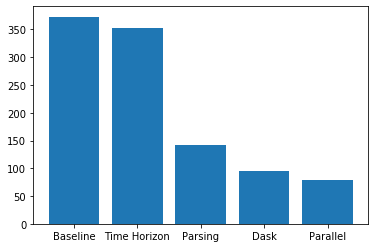

In [116]:
plt.bar(comp.keys(), comp.values())

In [119]:
comp['Baseline']/comp['Parallel']

4.782051282051282

<BarContainer object of 2 artists>

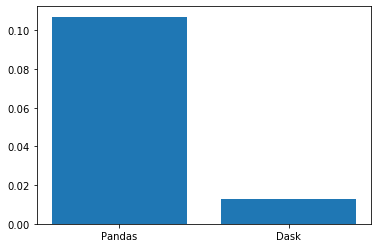

In [117]:
plt.bar(read.keys(), read.values())

In [120]:
read['Pandas']/read['Dask']

8.3671875

It was shown that the "grown" code which is adapted again and again over time needs some facelift every now and then, and the tools above can help a lot!


### so... boost yourself to boost your code!
When starting a new project one always has to weigh on if there should be an implementation available as fast as possible, or if the implementation should be long lasting and reusable also in future. Therefore, I suggest to spend at least some thoughts on what is the overall goal and if it would be better to spend more time in planning and specifications instead of just starting to code.

However, this is the process of learning and self improvement, and no perfect result can exist without having had some iterations and making failures. Therefore I want to finish this article with a (german) quotation:
> "*Und doch, ist nicht dies das Leben -? ich glaube: daß aus so viel dürftigen, bangen, kleinlichen und schmählichen Einzelheiten sich am Ende doch ein großartiges Ganzes zusammensetzt, das ja nicht wäre, wenn wirs verstünden und leisteten, sondern an dem wir mit unserem Können und unserem Mißlingen gleich weit beteiligt sind.*"
> *-- Rainer Maria Rilke --*